# Maritime Trade: Train 2020 XGBoost RAPIDS GPU 
## Hyperopt Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/RAPIDS/

/content/drive/MyDrive/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!pip install pynvml
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 4.9 MB/s 
Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 312 (delta 82), reused 98 (delta 55), pack-reused 171
Receiving objects: 100% (312/312), 90.55 KiB | 1.68 MiB/s, done.
Resolving deltas: 100% (144/144), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,073 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get

In [ ]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [ ]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.15.0
Uninstalling cffi-1.15.0:
  Successfully uninstalled cffi-1.15.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cffi-1.15.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (446 kB)
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.2
    - dask-sql
    - gcsfs
    - llvmlite
    - openssl
    - python=3.8.15
    - rapids=21.12


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _ipython_minor_entry_point-8.7.0|       h3b92ee0_0           6 KB  conda-forge
    abseil-cpp-20211102.0      

In [ ]:
# Install/import dependencies
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install eli5
import os
import warnings
import random
import numpy as np
import cupy 
from cupy import asnumpy
import dask
from dask.distributed import Client, wait
from dask.diagnostics import ProgressBar
from dask.utils import parse_bytes
from dask_cuda import LocalCUDACluster
import dask_cudf
import urllib.request
from contextlib import contextmanager
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import cudf
import cuml
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
import ast
import joblib
from joblib import parallel_backend
import pickle
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
my_dpi = 96
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Mon Dec 12 01:02:37 2022       
+---------------------------------------------------------------

In [ ]:
# Set seed 
seed_value = 42
os.environ['xgbRAPIDS_GPU'] = str(seed_value)
random.seed(seed_value)
cupy.random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', 
                           dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://172.28.0.12:8081/status,
Dashboard: http://172.28.0.12:8081/status,Workers: 1
Total threads: 1,Total memory: 25.45 GiB
Status: running,Using processes: True
Comm: tcp://172.28.0.12:35489,Workers: 1
Dashboard: http://172.28.0.12:8081/status,Total threads: 1
Started: Just now,Total memory: 25.45 GiB
Comm: tcp://172.28.0.12:35549,Total threads: 1
Dashboard: http://172.28.0.12:42039/status,Memory: 25.45 GiB
Nanny: tcp://172.28.0.12:36605,


In [ ]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = cudf.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633785, 20)


In [ ]:
# Create year-week for stratification
df['DateTime']= cudf.to_datetime(df['DateTime']) 
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

df = df.drop(['DateTime'], axis=1)

In [ ]:
# Filter data to yearly
df1 = df[df['Year'] == 2019]

# Filter df to 2020
df2 = df[df['Year'] == 2020]

del df

# Drop year variable
df1 = df1.drop(['Year'], axis=1)
df1 = df1.to_pandas()
df2 = df2.drop(['Year'], axis=1)
df2 = df2.to_pandas()

In [ ]:
# Prepare for partitioning data
X = df2.drop(['Metric_Tons'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.DateTime_YearWeek,
                                                    random_state=seed_value)

In [ ]:
# Drop time variable
X_train = X_train.drop(['DateTime_YearWeek'], axis=1)
X_test = X_test.drop(['DateTime_YearWeek'], axis=1)

In [ ]:
# Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(mn.transform(X_test), columns=X_test.columns)

In [ ]:
# Convert back to cudf
X_train = cudf.DataFrame.from_pandas(X_train)
X_test = cudf.DataFrame.from_pandas(X_test)

In [ ]:
# Convert data type for modeling
X_train = X_train.astype('float32')
y_train = y_train.astype('int32')

X_test = X_test.astype('float32')
y_test = y_test.astype('int32')

## 100 Trials Train/Test

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Hyperparameter space
xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 700, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 25, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.95),
    'gamma': hp.uniform('gamma', 0, 15),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 100),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.95),  
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 30, 
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):
    """XGBoost HPO"""

    joblib.dump(bayesOpt_trials, 'xgbRapids_Hyperopt_100_GPU_Train20.pkl')  

    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])   
    
    # Start hyperopt at 3 for max_depth   
    config['max_depth'] = int(config['max_depth']) + 3
    
    # Define model type
    xgb = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree', 
        tree_method='gpu_hist',    
        scale_pos_weight=1,
        use_label_encoder=False,
        random_state=seed_value,
        verbosity=0,
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Fit model
    xgb.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)],
            verbose=0)    
    run_time = timer() - start
    
    # Predictions
    y_pred_val = xgb.predict(X_test)
    mae = mean_absolute_error(asnumpy(y_test), asnumpy(y_pred_val))
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([mae, config, ITERATION, run_time])
    
    return {'loss': mae, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = '/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/xgbRapids_HPO_Train20_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials 
if os.path.isfile('xgbRapids_Hyperopt_100_GPU_Train20.pkl'): 
    bayesOpt_trials = joblib.load('xgbRapids_Hyperopt_100_GPU_Train20.pkl')
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                      max_evals=NUM_EVAL, trials=bayesOpt_trials)
else: 
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                      max_evals=NUM_EVAL, trials=bayesOpt_trials)

98%|██████████| 98/100 [6:36:44, 300.97s/it, best loss: 5.002324578196533]


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Access results
results = pd.read_csv('xgbRapids_HPO_Train20_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)
results.to_csv('xgbRapids_HPO_Train20_100_GPU.csv')

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror', 
                                booster='gbtree',
                                tree_method='gpu_hist', 
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0,
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'xgbRapids_HPO_Train20_100trials_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('xgbRapids_HPO_Train20_100trials_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train 2020 Test 2020 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_absolute_error(asnumpy(y_test), asnumpy(y_test_pred))))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_squared_error(asnumpy(y_test), asnumpy(y_test_pred))))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred), squared=False),
        mean_squared_error(asnumpy(y_test), asnumpy(y_test_pred), squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(asnumpy(y_train), asnumpy(y_train_pred)),
        r2_score(asnumpy(y_test), asnumpy(y_test_pred))))


Model Metrics for XGBoost HPO Train 2020 Test 2020 100 GPU trials
MAE train: 2.999, test: 5.065
MSE train: 47.560, test: 155.987
RMSE train: 6.896, test: 12.489
R^2 train: 0.950, test: 0.836


In [ ]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(asnumpy(y_test), 
                                                                                                            asnumpy(y_test_pred))))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 155.98724 MSE on the test set.
This was achieved after 3 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_xgbRapids_HPO_Train20_100_GPU.csv', 
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

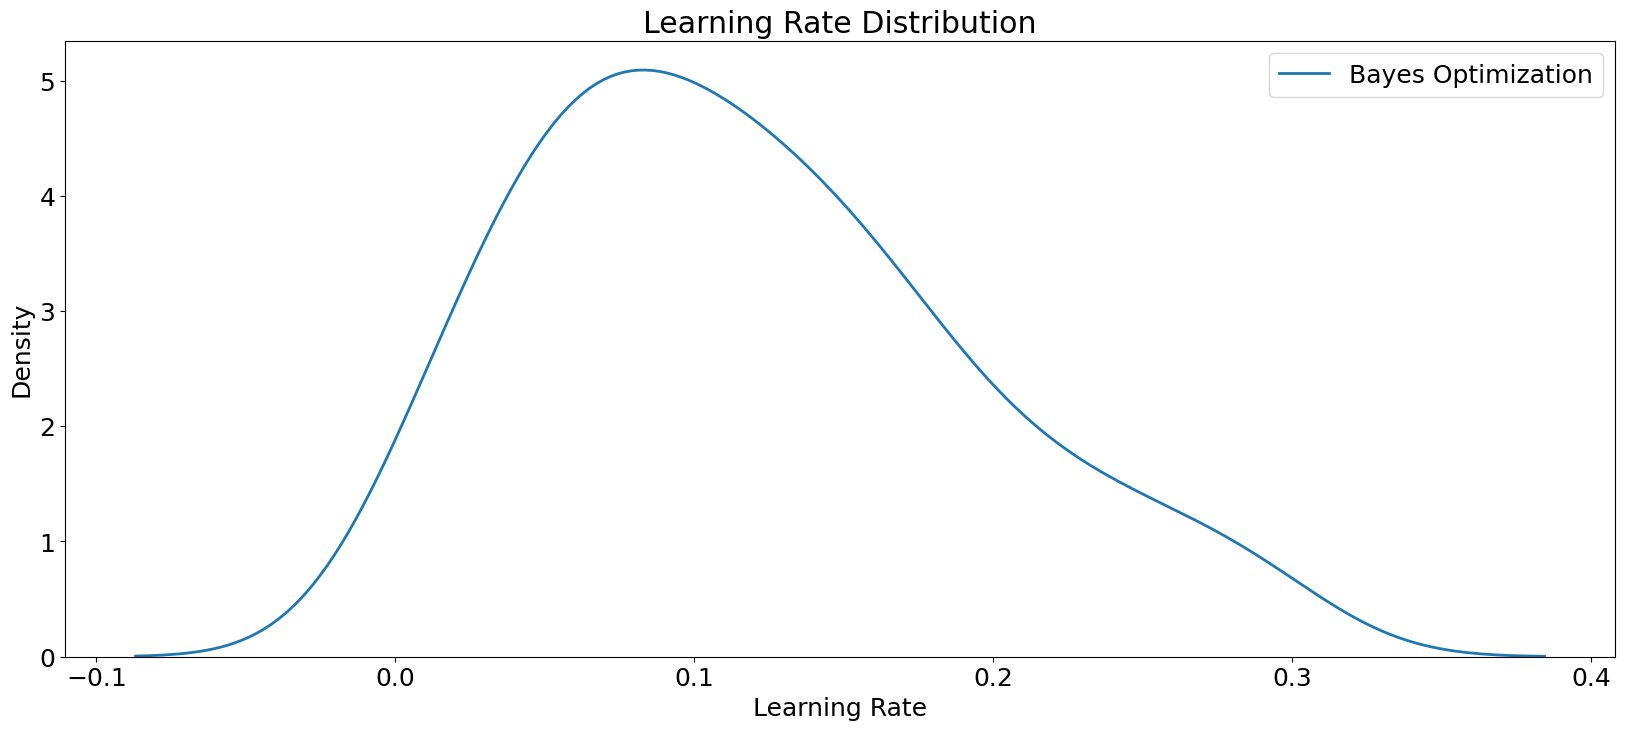

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization', 
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

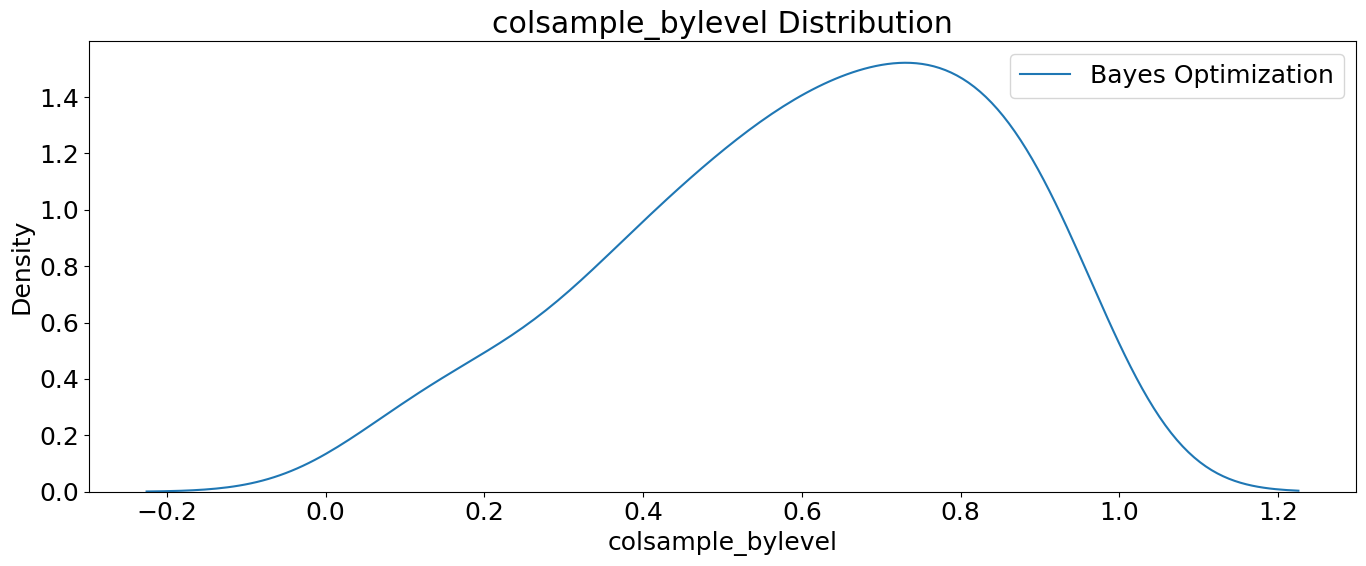

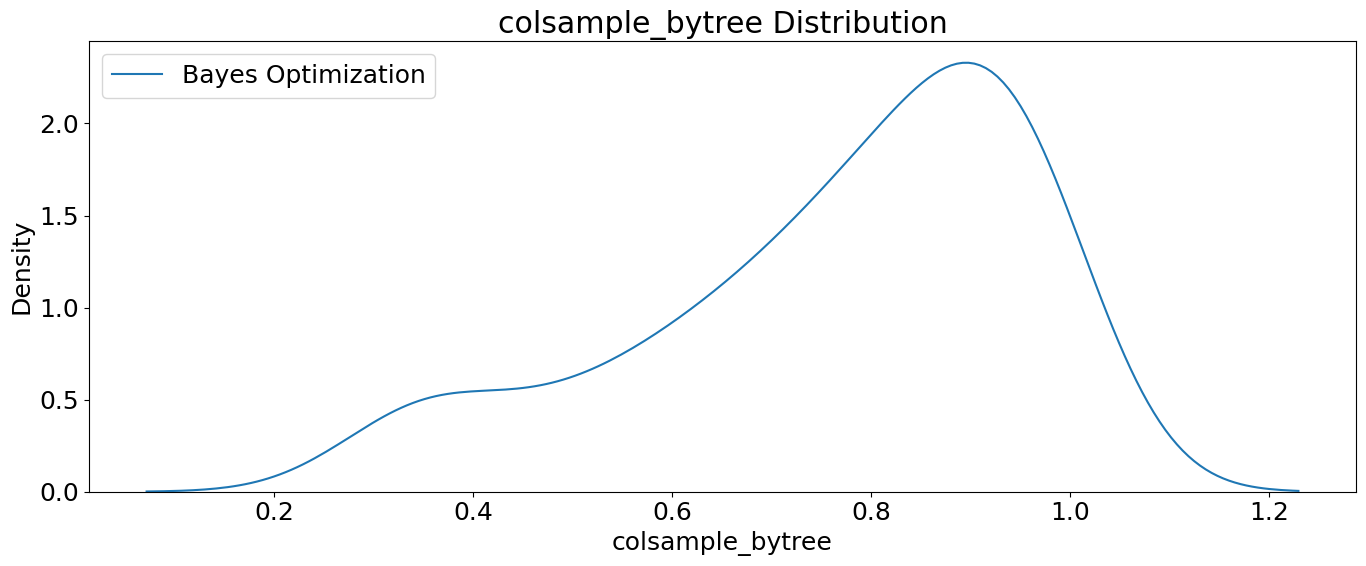

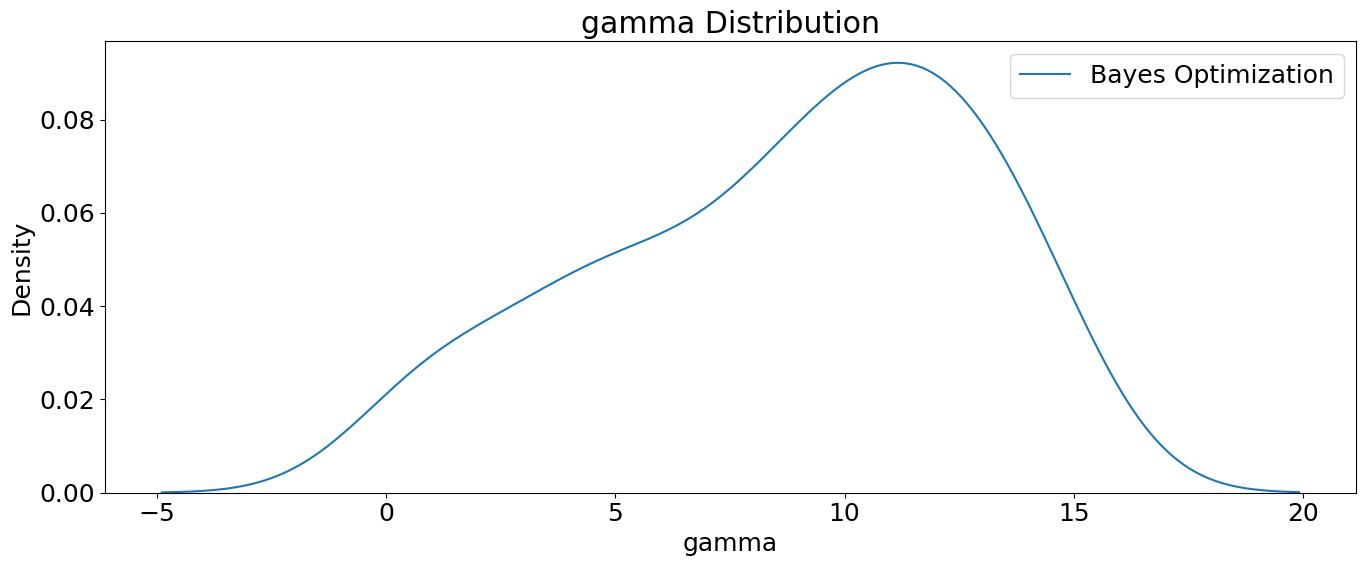

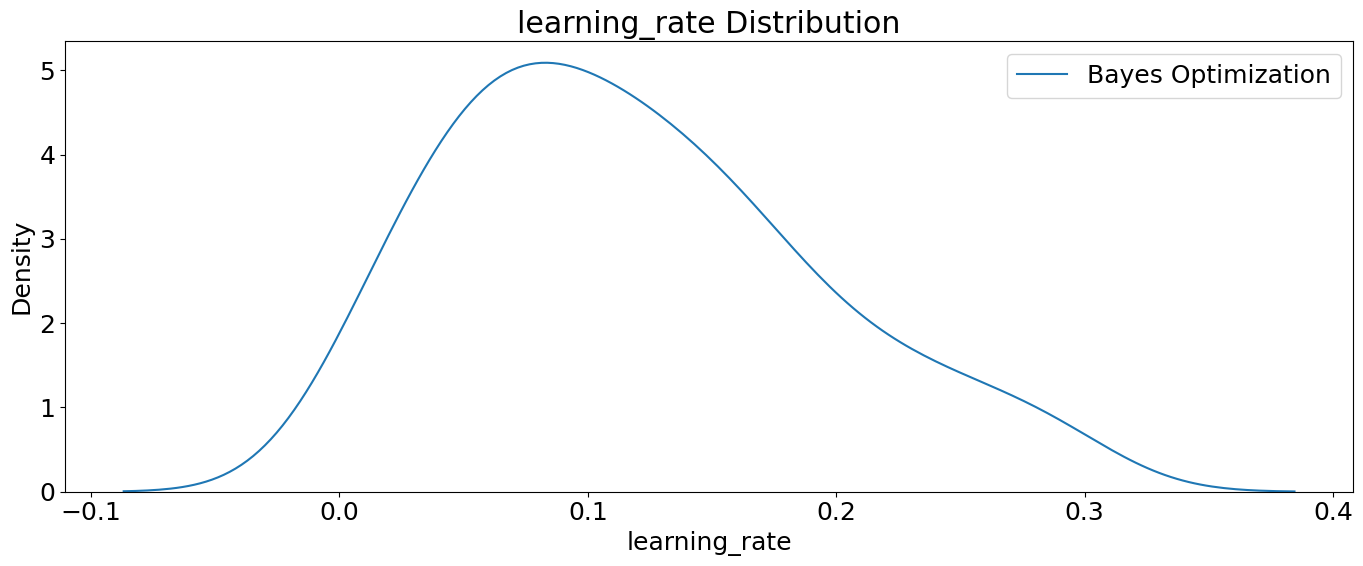

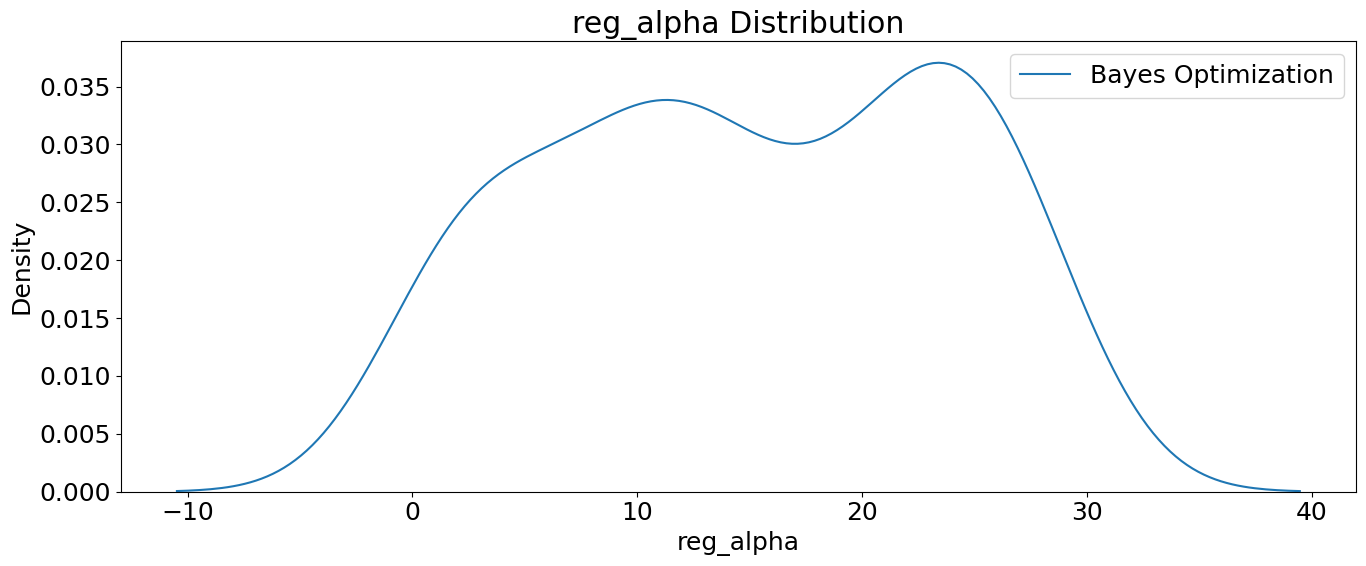

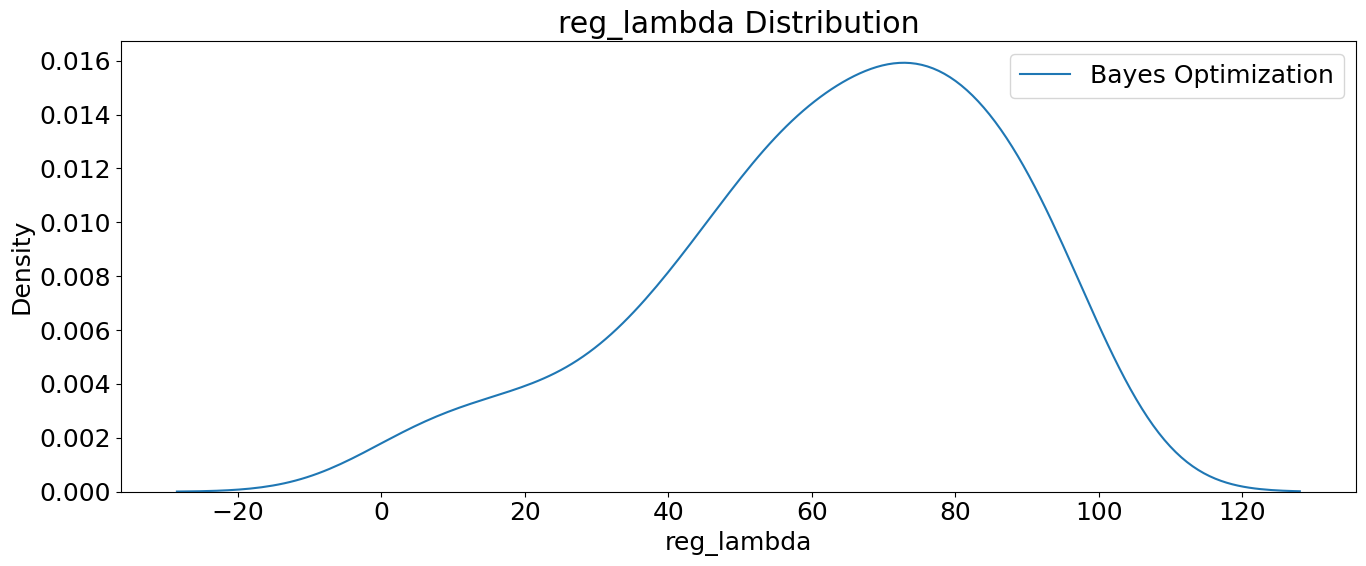

<Figure size 1400x600 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

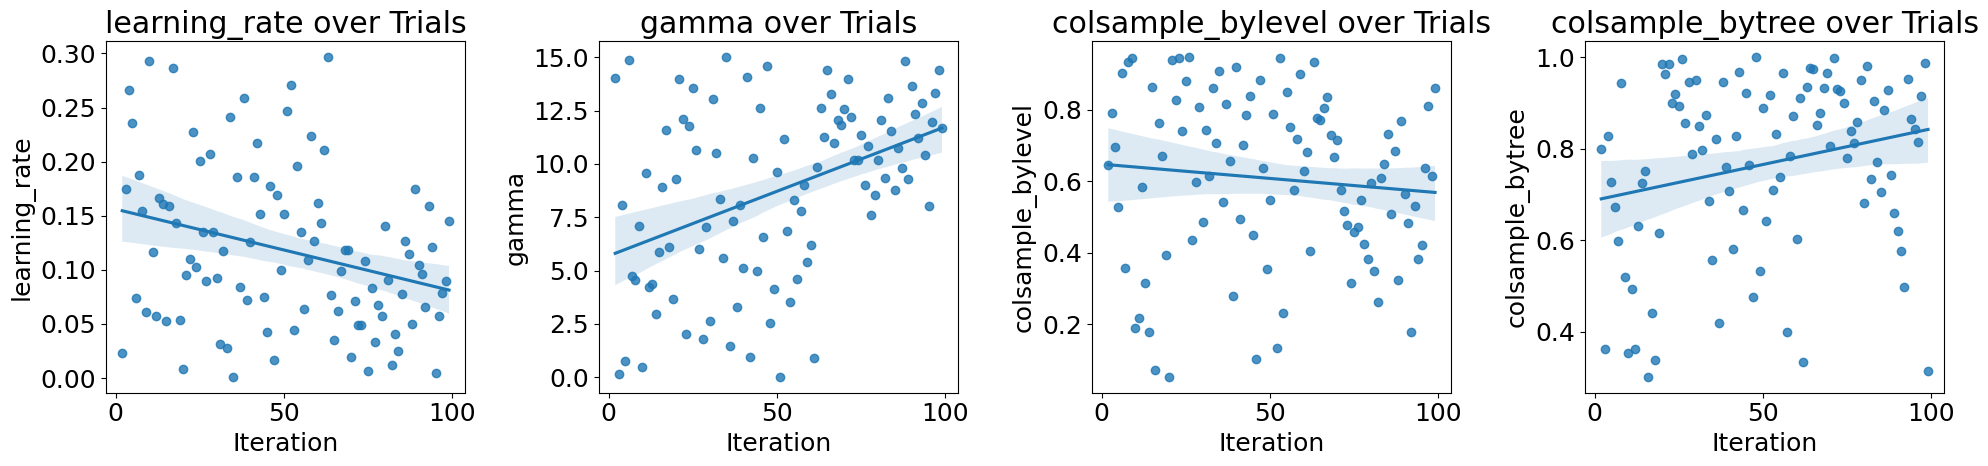

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
               title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

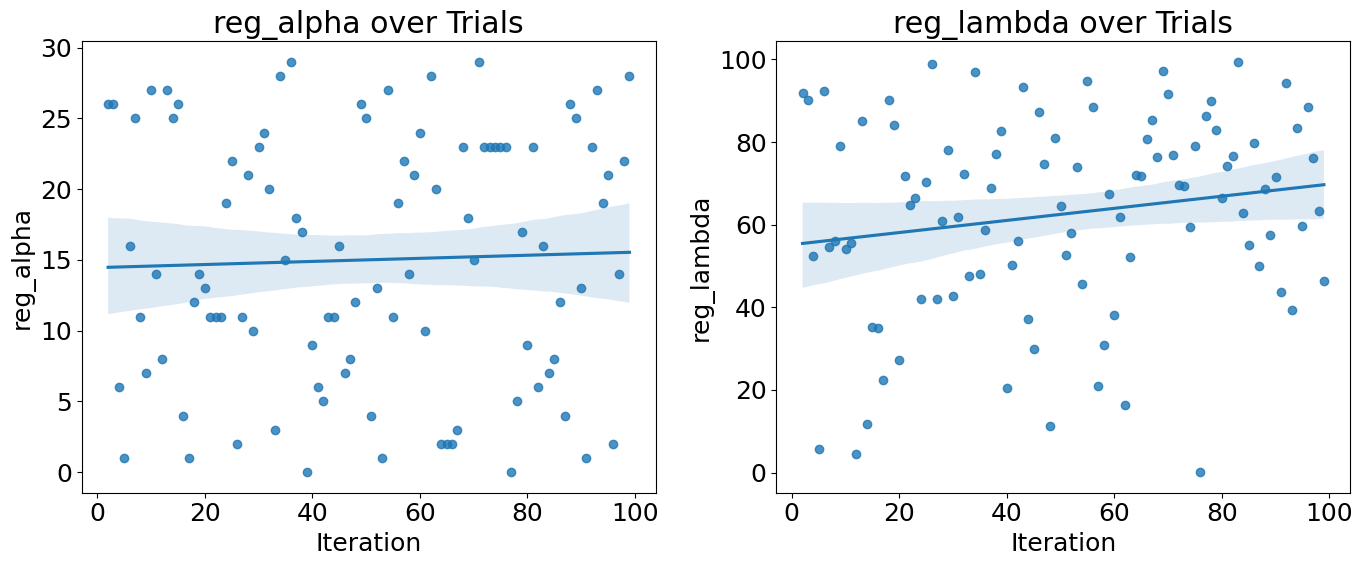

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
               title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


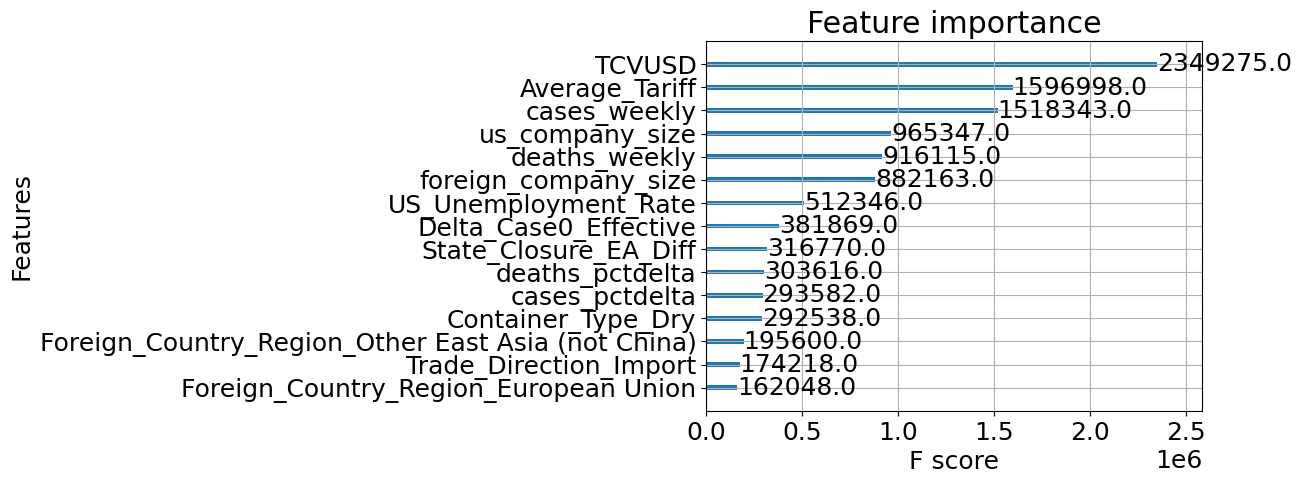

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('xgbRapids_HPO_Train20_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test.to_numpy(),
                                                                     y_test.to_numpy())

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test.to_pandas(), columns=X_test.columns)                                                                    

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_HPO_Train20_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_HPO_Train20_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj 

Weight,Feature
1.1318 ± 0.0053,TCVUSD
0.4131 ± 0.0012,Average_Tariff
0.2764 ± 0.0055,HS_Group_Name_Finished Goods
0.1746 ± 0.0024,Trade_Direction_Import
0.1738 ± 0.0009,HS_Group_Name_Raw Input
0.1057 ± 0.0008,foreign_company_size
0.1035 ± 0.0011,us_company_size
0.0627 ± 0.0011,Delta_Case0_Effective
0.0490 ± 0.0011,Foreign_Country_Region_South Asia
0.0448 ± 0.0014,Foreign_Country_Region_European Union


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_xgbRapids_HPO_Train20_100_GPU_WeightsExplain.csv',
           index=False)
exp

,feature,weight,std
0,TCVUSD,1.131809,0.002670
1,Average_Tariff,0.413096,0.000620
2,HS_Group_Name_Finished Goods,0.276361,0.002752
3,Trade_Direction_Import,0.174613,0.001179
4,HS_Group_Name_Raw Input,0.173788,0.000453
5,foreign_company_size,0.105692,0.000394
6,us_company_size,0.103508,0.000532
7,Delta_Case0_Effective,0.062671,0.000569
8,Foreign_Country_Region_South Asia,0.049041,0.000552
9,Foreign_Country_Region_European Union,0.044832,0.000685


### Test on 2019

In [ ]:
# Prepare 2019 to fit model train on 2020
X_test1 = df1.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y_test1 = df1['Metric_Tons']

In [ ]:
# Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Convert back to cudf
X_test1 = cudf.DataFrame.from_pandas(X_test1)

# Convert data type for modeling
X_test1 = X_test1.astype('float32')
y_test1 = y_test1.astype('int32')

In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2020 Test 2019')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_absolute_error(asnumpy(y_test1), asnumpy(y_test_pred))))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_squared_error(asnumpy(y_test1), asnumpy(y_test_pred))))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred), squared=False),
        mean_squared_error(asnumpy(y_test1), asnumpy(y_test_pred), squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(asnumpy(y_train), asnumpy(y_train_pred)),
        r2_score(asnumpy(y_test1), asnumpy(y_test_pred))))


Model Metrics for XGBoost HPO Train 2020 Test 2019
MAE train: 2.999, test: 3.519
MSE train: 47.560, test: 78.984
RMSE train: 6.896, test: 8.887
R^2 train: 0.950, test: 0.922


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

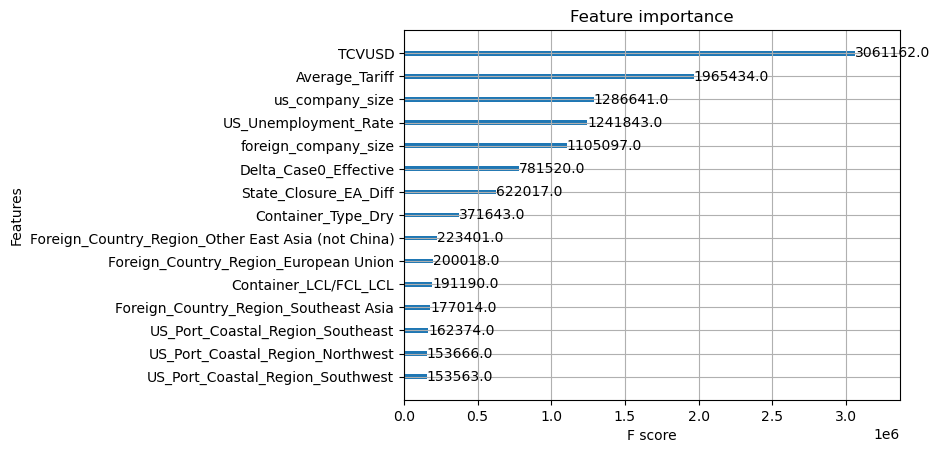

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('xgbRapids_HPO_train20test19_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1.to_numpy(),
                                                                     y_test1.to_numpy())

In [ ]:
# Store feature weights in an object
X1_test1 = pd.DataFrame(X_test1.to_pandas(), columns=X_test1.columns)

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X1_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_100_GPU_train20test19_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_100_GPU_train20test19_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
1.2398 ± 0.0020,TCVUSD
0.4819 ± 0.0015,Average_Tariff
0.2748 ± 0.0006,HS_Group_Name_Finished Goods
0.2446 ± 0.0002,foreign_company_size
0.2110 ± 0.0009,HS_Group_Name_Raw Input
0.1564 ± 0.0007,us_company_size
0.1444 ± 0.0002,Trade_Direction_Import
0.1013 ± 0.0007,Delta_Case0_Effective
0.0609 ± 0.0003,Foreign_Country_Region_European Union
0.0547 ± 0.0004,State_Closure_EA_Diff


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X1_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_xgbRapids_100_GPU_train20test19_WeightsFeatures.csv',
           index=False)
exp

,feature,weight,std
0,TCVUSD,1.239769,0.001000
1,Average_Tariff,0.481857,0.000740
2,HS_Group_Name_Finished Goods,0.274777,0.000282
3,foreign_company_size,0.244605,0.000121
4,HS_Group_Name_Raw Input,0.211019,0.000443
5,us_company_size,0.156423,0.000327
6,Trade_Direction_Import,0.144351,0.000122
7,Delta_Case0_Effective,0.101251,0.000325
8,Foreign_Country_Region_European Union,0.060932,0.000170
9,State_Closure_EA_Diff,0.054713,0.000224


### Test on 2010 - 2019

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

In [ ]:
# Read data
df = cudf.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df.to_pandas()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna() & 
        df.State_Closure_EA_Diff.notna()]
df = df[df['Year'] < 2020]
print('Number of rows and columns:', df.shape)

Number of rows and columns: (24133210, 19)


In [ ]:
# Prepare for partitioning data
X = df.drop(['Metric_Tons', 'DateTime', 'Year'], axis=1)
y = df['Metric_Tons']

del df

In [ ]:
# Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

In [ ]:
# Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.fit_transform(X_test1), columns=X_test1.columns)

In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

In [ ]:
# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2020 Test 2010-19')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_absolute_error(asnumpy(y_test1), asnumpy(y_test_pred))))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_squared_error(asnumpy(y_test1), asnumpy(y_test_pred))))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred), squared=False),
        mean_squared_error(asnumpy(y_test1), asnumpy(y_test_pred), squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(asnumpy(y_train), asnumpy(y_train_pred)),
        r2_score(asnumpy(y_test1), asnumpy(y_test_pred))))


Model Metrics for XGBoost HPO Train 2020 Test 2010-19
MAE train: 2.999, test: 3.519
MSE train: 47.560, test: 78.984
RMSE train: 6.896, test: 8.887
R^2 train: 0.950, test: 0.922


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

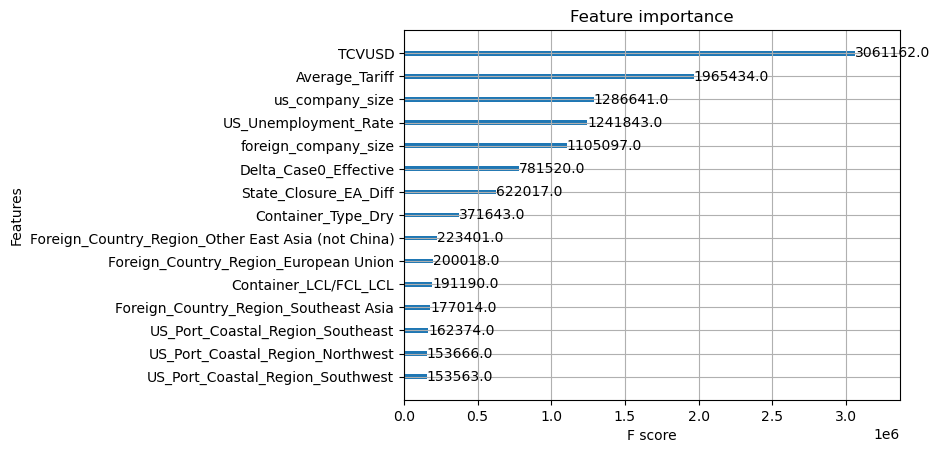

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('xgbRapids_HPO_trainPreCOVIDTest20_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1.to_numpy(),
                                                                     y_test1.to_numpy())

In [ ]:
# Store feature weights in an object
X1_test1 = pd.DataFrame(X_test1.to_pandas(), columns=X_test1.columns) 

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X1_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_HPO_100_GPU_train20test1019_WeightsFeatures.htm',
           'wb') as f:
     f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_HPO_100_GPU_train20test1019_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
1.2398 ± 0.0020,TCVUSD
0.4819 ± 0.0015,Average_Tariff
0.2748 ± 0.0006,HS_Group_Name_Finished Goods
0.2446 ± 0.0002,foreign_company_size
0.2110 ± 0.0009,HS_Group_Name_Raw Input
0.1564 ± 0.0007,us_company_size
0.1444 ± 0.0002,Trade_Direction_Import
0.1013 ± 0.0007,Delta_Case0_Effective
0.0609 ± 0.0003,Foreign_Country_Region_European Union
0.0547 ± 0.0004,State_Closure_EA_Diff


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X1_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_xgbRapids_HPO_100_GPU_train20test1019_WeightsFeatures.csv',
           index=False)
exp

,feature,weight,std
0,TCVUSD,1.239769,0.001000
1,Average_Tariff,0.481857,0.000740
2,HS_Group_Name_Finished Goods,0.274777,0.000282
3,foreign_company_size,0.244605,0.000121
4,HS_Group_Name_Raw Input,0.211019,0.000443
5,us_company_size,0.156423,0.000327
6,Trade_Direction_Import,0.144351,0.000122
7,Delta_Case0_Effective,0.101251,0.000325
8,Foreign_Country_Region_European Union,0.060932,0.000170
9,State_Closure_EA_Diff,0.054713,0.000224
